# exp004_eval
[Notion](https://www.notion.so/exp004-5a9b8ebe2c1a45e39b567acbc3b86583?pvs=4)  
セグメンテーションの評価コード  

In [1]:
import os
import random
import sys
import warnings
warnings.filterwarnings('ignore')
from typing import Any, Tuple
from collections import defaultdict

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import torch
import seaborn as sns
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

# リポジトリtopに移動
while os.path.basename(os.getcwd()) != 'rsna-2023':
    os.chdir('../')
    if os.getcwd() == '/':
        raise Exception('Could not find project root directory.')
    
from src.segmentation.dataset import TestDataset, load_df
from src.image_processing import windowing
from src.visualization import apply_colormap_to_multilabel_images
from src.metrics import calc_cfm_metrics
from src.model import load_models
from src.trainer import evaluate

# Config

In [2]:
class CFG:
    exp_name = 'exp_004'
    # model config
    backbone = 'efficientnet-b3'
    n_ch = 1
    n_class = 4 # 学習時は腎臓の左右を区別しないので、5->4
    # hyper params
    init_lr = 1e-3
    min_lr = 1e-6
    weight_decay = 1e-4
    image_size = (512, 512)
    batch_size = 32
    amp = True
    n_epoch = 20
    iteration_per_epoch = 200
    pretrain = True
    freeze_epochs = 1
    noaug_epochs = 1
    # fold config
    n_fold = 6
    include_evaluation = False
    train_folds = 1
    # path
    image_dir = "data/dataset001/train_images"
    mask_dir = "data/dataset001/segmentations"
    model_save_dir = "outputs"
    # other config
    seed = 42
    num_workers = 0
    num_gpus = 2
    progress_bar = True
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# create output dir
os.makedirs(os.path.join(CFG.model_save_dir, CFG.exp_name), exist_ok=True)

# get label correspondences
organ_index_dict_inv = {
    0: 'liver',
    1: 'spleen',
    2: 'kidney',
    3: 'bowel'
}
organ_index_dict = {v: k for k, v in organ_index_dict_inv.items()}

# Dataset

In [4]:
# load dataframe
df = load_df(CFG)
df.head()
df_eval = df[df["fold"] == 0].reset_index(drop=True)
df_eval_series = df_eval[["patient_id", "series_id"]].drop_duplicates().reset_index(drop=True)

In [5]:
def apply_preprocess(image: np.ndarray, mask: np.ndarray)-> Tuple[np.ndarray, np.ndarray]:
    """データ前処理. カスタマイズして使用.
    Args:
        image (numpy.ndarray): HU値のCT画像.
        mask (numpy.ndarray): channel lastのマスク画像.
    Returns:
        image (numpy.ndarray): windowing及び0~1に正規化.
        mask (numpy.ndarray): channel lastのマスク画像.
    """
    # 0~1に正規化
    image = windowing(image, wl=0, ww=400, mode="float32")
    return image, mask



# Load models

In [6]:
# モデルの読み込み
models = load_models(CFG, mode="final")

# Evaluation

In [7]:
def evaluate_series(CFG: Any, df: pd.DataFrame, models: list, pid: int, sid: int) -> dict:
    """患者ごと(シリーズごと)の評価を行う.
    Args:
        CFG (Any): Config
        models (list): 学習済みモデルのリスト
        pid (int): 患者ID
        sid (int): シリーズID
    Returns:
        dict: 評価結果
    """
    # 評価用データセットの作成
    df_res = df[(df["patient_id"] == pid) & (df["series_id"] == sid)].reset_index(drop=True)
    ds = TestDataset(CFG, df_res, preprocess=apply_preprocess)
    eval_iterator = DataLoader(
        ds,
        shuffle=False,
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers
    )
    # 推論
    result = evaluate(CFG, models, eval_iterator)
    return result

In [8]:
pid, sid = df_eval["patient_id"][0], df_eval["series_id"][0]
result = evaluate_series(CFG, df_eval, models, pid, sid)

In [9]:
result["image"].shape, result["label"].shape, result["pred"].shape

((53, 512, 512, 1), (53, 512, 512, 4), (53, 512, 512, 4))

# Visualize

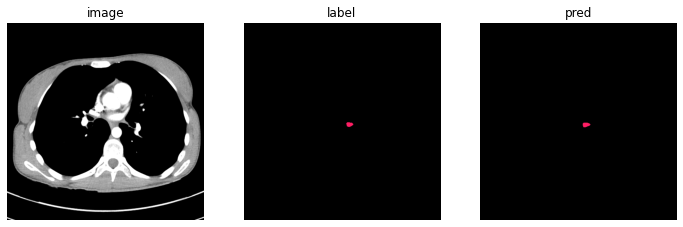

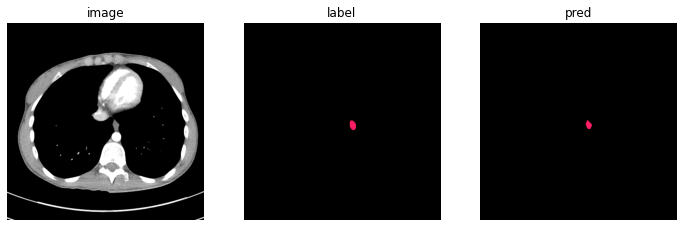

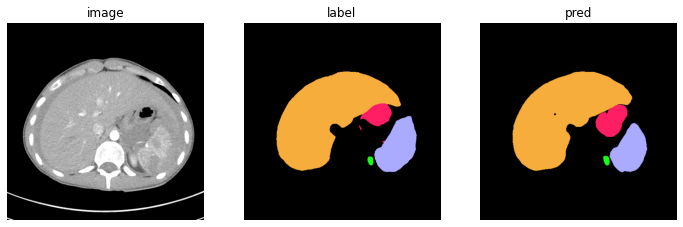

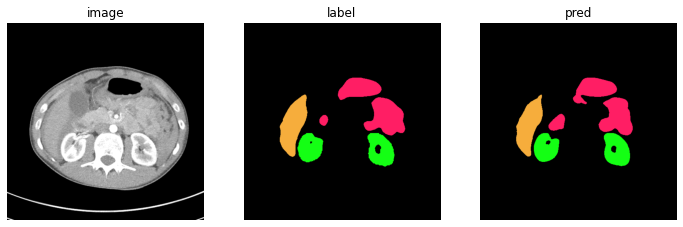

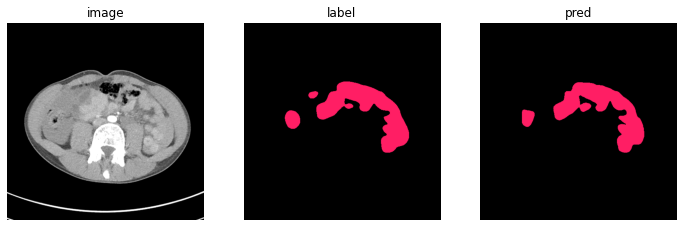

In [10]:
def visualize_slice(pred_result: dict, rows: int=4):
    """image, label, predを並べて表示."""
    l = len(pred_result["image"])
    for i in range(0, l, l//rows):
        fig, ax = plt.subplots(1, 3, figsize=(12, 4*rows))
        image = pred_result["image"][i, :, :, 0]
        pred_binary = (pred_result["pred"][i] > 0.5).astype(np.uint8)
        label_cmap = apply_colormap_to_multilabel_images(CFG, pred_result["label"][i])
        pred_cmap = apply_colormap_to_multilabel_images(CFG, pred_binary)

        ax[0].imshow(image, cmap="gray")
        ax[0].set_title("image")
        ax[1].imshow(label_cmap)
        ax[1].set_title("label")
        ax[2].imshow(pred_cmap)
        ax[2].set_title("pred")
        for i in range(3):
            ax[i].axis("off")
    plt.show()

visualize_slice(result, rows=4)

# Quantitative Evaluation  
今回1シリーズ1000スライスを超える場合があるため、Hausdorff距離の算出はスキップする.  
Dice係数のみ算出.

In [11]:
metrics = dict()
print("===evaluate metrics===")
for i in tqdm(range(len(df_eval_series))):
    pid, sid = df_eval_series["patient_id"][i], df_eval_series["series_id"][i]
    result = evaluate_series(CFG, df_eval, models, pid, sid)
    
    # Precision, Recall, Dice係数の算出
    pred = (result["pred"] > 0.5).astype(np.uint8)
    label = result["label"]
    cfm_metrics = calc_cfm_metrics(label, pred)
    # hausdorff = get_hausdorff_3d(label, pred)
    metrics[f"{pid}_{sid}"] = cfm_metrics
    # metrics[f"{pid}_{sid}"]["hausdorff"] = hausdorff

===evaluate metrics===


100%|██████████| 33/33 [06:54<00:00, 12.56s/it]


In [12]:
df_base = defaultdict(list)
for pid_sid in metrics.keys():
    for organ, index in organ_index_dict.items():
        df_base["pid_sid"].append(pid_sid)
        df_base["organ"].append(organ)
        for metric in ["precision", "recall", "dice"]:
            df_base[metric].append(metrics[pid_sid][metric][index])
eval_df = pd.DataFrame(df_base)
eval_df.head()
# csvで保存
eval_df.to_csv(os.path.join(CFG.model_save_dir, CFG.exp_name, f"{CFG.exp_name}_eval.csv"), index=False)

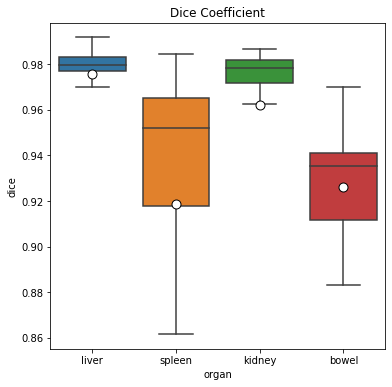

In [13]:
# seabornのboxplotで、臓器ごとのDice係数を表示.
plt.figure(figsize=(6, 6))
sns.boxplot(
    x="organ",
    y="dice",
    data=eval_df,
    showmeans=True,
    meanprops = {
        "marker":"o",
        "markerfacecolor":"white",
        "markeredgecolor":"black",
        "markersize":"9"
    },
    showfliers=False,
)
plt.title("Dice Coefficient")
plt.show()